In [1]:
# !python parallelosaurus.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib as mpl
import glob

In [98]:
df_master = pd.read_csv("minisaurus_net_test_lim.csv").fillna(0).drop(columns=['model_number', 'gyre_fn', 'num_zones', 
                                                                    'priority','star_age', 'num_retries','num_iters'])
cols = ['m', 'z', 'v', 'tr_num', 'Myr', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0', 'n5ell0m0',
       'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0', 'n1ell1m0',
       'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0', 'n7ell1m0',
       'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'Dnu', 'eps', 'n1ell1dfreq',
       'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
       'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
       'n10ell1dfreq']
df_master = df_master[cols]
df_master.columns

Index(['m', 'z', 'v', 'tr_num', 'Myr', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0',
       'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0',
       'n10ell0m0', 'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0',
       'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'Dnu',
       'eps', 'n1ell1dfreq', 'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq',
       'n5ell1dfreq', 'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq',
       'n9ell1dfreq', 'n10ell1dfreq'],
      dtype='object')

In [ ]:
hist = pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/history.data", skiprows=5, delim_whitespace=True)
profile_index = pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/profiles.index", skiprows=1, 
                            names=['model_number', 'priority', 'profile_number'], delim_whitespace=True)

profiles = []
ages = []
old = 0
for i, row in hist.iterrows():
    age = row.star_age/1e6
    new = int(age) + int(age * 10) % 10
    hist_model = row.model_number
    profile_model = profile_index.query(f"model_number=={row.model_number}").model_number.values
    if len(profile_model) !=0:
        profile_model = profile_model[0]
        if hist_model == profile_model:
            profile_number = profile_index.query(f"model_number=={row.model_number}").profile_number.values[0]
            if new > old:
                ages.append(new)
                profiles.append(pd.read_csv(f"test_1.7_z/m{m}_z{z}_v0/LOGS/profile{profile_number}.data", 
                                            skiprows=5, delim_whitespace=True))
                old = new

In [4]:
def plot_2d(args):
    plt.cla()
    age, profile = args
    palette = sns.color_palette("flare", len(profile))
    theta = np.linspace(0, 2*np.pi, 100)  # 100 points evenly spaced from 0 to 2*pi
    radius_max = 10**profile.logR.max()
    densities = 10**profile.logRho.sort_values()
    for i, row in profile.iterrows():
        radius = 10**row.logR
        # Convert 1D values to 2D Cartesian coordinates
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        di = np.where(densities == 10**row.logRho)[0][0]
        plt.plot(x, y, lw=1, color=palette[di])
    r = 5
    plt.xlim(-r, r)
    plt.ylim(-r, r)
    plt.title(f"Age: {age} Myr")


In [5]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

fig = plt.figure(figsize=(6, 6))
ani = FuncAnimation(fig, plot_2d, frames=zip(ages, profiles))

NameError: name 'plot_2d' is not defined

<Figure size 600x600 with 0 Axes>

In [14]:
writer = animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264', '-preset', 'slow', '-crf', '18'])
ani.save(f'figures/2d.mp4', writer=writer)

MovieWriter ffmpeg unavailable; using Pillow instead.


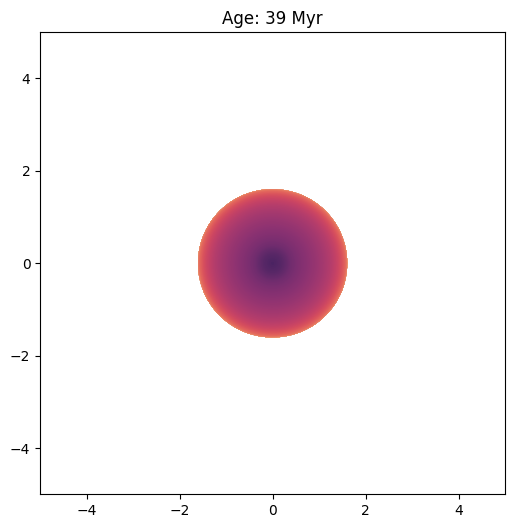

In [37]:
import time
from IPython import display

with plt.ion():
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    for i, profile in enumerate(profiles):
        try:
            palette = sns.color_palette("flare", len(profile))
            args = ages[i], profile
            plot_2d(args)
            # plt.colorbar(10**profile.logRho, label='Density')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            # time.sleep(0.1)
        except KeyboardInterrupt:
            break

In [285]:
ref = 3
# ages_t = np.arange(df_master[df_master.tr_num == ref].Myr.values[0], 1500, 0.1)


dfs = []
age_lists = []
for tr_num in range(5):
    this_df = df_master[df_master.tr_num == tr_num]
    this_df = this_df.sort_values(by='Myr').reset_index()
    new_df = pd.DataFrame()
    new_df['Myr'] = np.arange(5, 500, 0.1)
    for col in this_df.columns:
        if col not in ['index', 'Myr', 'tr_num', 'm', 'v', 'z']:
            f = interp1d(this_df["Myr"], this_df[col], kind='slinear', fill_value='extrapolate')
            new_df[col] = f(new_df['Myr'])
    dfs.append(new_df)


# dfs = []
# for tr_num in range(5):
#     this_df = df[df.tr_num == tr_num]
#     dfs.append(this_df.sort_values(by='Myr').reset_index())


In [140]:
cols0 = ['n1ell0m0', 'n2ell0m0', 'n3ell0m0',
       'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0',
       'n10ell0m0']

cols1 = ['n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0',
         'n5ell1m0', 'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0']

ref = 3
df_ref = dfs[ref]
# param_samples = np.round(np.append(np.arange(0.1, 1.4, 0.3), [1.25]), 3)
# print("ref param: ", param_samples[ref])
mean_diffs = []
ages = []


for this_df in dfs:
    this_mean = []
    age = []
    for i, row in df_ref.iterrows():
        freqs_ref_0 = row[cols0]
        freqs_ref_1 = row[cols1]
        freqs_alt_0 = this_df.iloc[i][cols0]
        freqs_alt_1 = this_df.iloc[i][cols1]
        diff_0 = ((freqs_ref_0 - freqs_alt_0)/freqs_ref_0).fillna(0)
        diff_1 = ((freqs_ref_1 - freqs_alt_1)/freqs_ref_1).fillna(0)
        this_mean.append(np.mean( np.append(diff_0, diff_1) ))
        age.append(row["Myr"])
        if row["Myr"] > 40:
            break
    ages.append(age)
    mean_diffs.append(this_mean)

In [17]:
diffs_save = np.array(mean_diffs)

In [18]:
# from scipy.signal import savgol_filter as filter
from scipy.signal import medfilt as filter
diffs = []
for i, mean_diff in enumerate(diffs_save):
    diffs.append(filter(mean_diff, 5))
mean_diffs = diffs

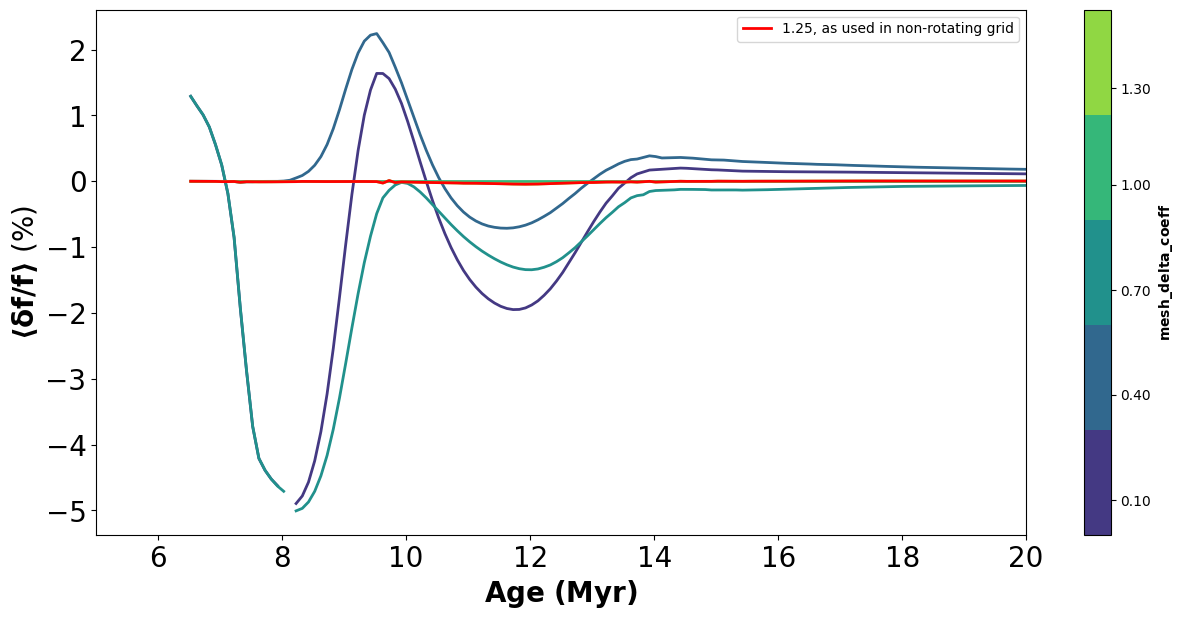

In [410]:
fig = plt.figure(figsize=(15, 15))
palette = sns.color_palette("viridis", len(dfs))
# palette = sns.color_palette("colorblind", len(var_samples))
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('long dash with offset', (5, (10, 3))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


ax1 = plt.subplot(2, 1, 1)
for ind, df in enumerate(dfs):
    plt.plot(ages[ind], 100*np.array(mean_diffs[ind]), color=palette[ind], lw=2)
plt.plot(ages[-1], 100*np.array(mean_diffs[-1]), lw=2, color='red', label=f'1.25, as used in non-rotating grid')
plt.legend(loc='upper right')

title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
plt.xlim([5, 20])
# plt.ylim([-0.3, 0.8])
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
# rect = mpl.patches.Rectangle((15, -0.001), 20, 0.004, linewidth=1, edgecolor='k', facecolor='grey', alpha=0.2)
# ax1.add_patch(rect)


# ax2 = plt.subplot(2, 1, 2)
# for ind, var in enumerate(var_samples):
#     # plt.plot(age, mean_diffs[ind], color=palette[ind], lw=2, linestyle=linestyle_tuple[ind][1])
#     plt.plot(ages[ind], mean_diffs[ind], color=palette[ind], lw=2)
# plt.plot(ages[-1], mean_diffs[-1], lw=2, color='red')
# plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
# plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
# plt.gca().xaxis.set_tick_params(labelsize=20)
# plt.gca().yaxis.set_tick_params(labelsize=20)
# plt.xlim([20, 500])
# plt.ylim([-0.01, 0.03])
# plt.subplots_adjust(wspace=0, hspace=0.3)


param_samples = np.arange(0.1, 1.4, 0.3)
Z = [[0,0],[0,0]]
levels = np.array(sorted(param_samples)+[1.7])
contour = plt.contourf(Z, levels, cmap=mpl.colors.ListedColormap(palette))
axes = [ax1]
cb = plt.colorbar(contour, ticks=levels+0.1, label=r'$\bf{mesh\_delta\_coeff}$', ax=axes)
cb.set_ticklabels([f"{level:.2f}" for level in levels])

# ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))
# ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol=''))

fig.align_ylabels([ax1])
plt.show()
# plt.savefig(f'../figures/mean_diff_panels.pdf', dpi=300, bbox_inches='tight')

In [298]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import medfilt 
from scipy.signal import savgol_filter 
from scipy.signal import symiirorder1
from scipy.signal import symiirorder2
from scipy.signal import wiener

from scipy.interpolate import UnivariateSpline
from scipy import stats

cols0 = ['n1ell0m0', 'n2ell0m0', 'n3ell0m0',
       'n4ell0m0', 'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0',
       'n10ell0m0']

cols1 = ['n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0',
         'n5ell1m0', 'n6ell1m0', 'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0']

def get_mean_rel_err(df, ref_df, cols0, cols1):
    mean_rel_err = []
    age = []
    for i, row in df.iterrows():
        t = row["Myr"]
        freqs_alt_0 = row[cols0]
        freqs_alt_1 = row[cols1]
        freqs_ref_0 = ref_df.query(f"Myr=={t}")[cols0]
        freqs_ref_1 = ref_df.query(f"Myr=={t}")[cols1]
        diff_0 = ((freqs_ref_0 - freqs_alt_0)/freqs_ref_0).fillna(0)
        diff_1 = ((freqs_ref_1 - freqs_alt_1)/freqs_ref_1).fillna(0)
        mean_rel_err.append(np.mean(np.append(diff_0, diff_1)))
        age.append(row["Myr"])
    return mean_rel_err, age


def age_uncertainty(df, ref_df, cols0, cols1):
    df = df.query("Myr < 40")
    ref_df = ref_df
    mean_rel_err, age = get_mean_rel_err(df, ref_df, cols0, cols1)
    mean_rel_err = np.array(mean_rel_err)
    # true_age = np.array(age)
    # true_dnu = ref_df["Dnu"].values
    # true_cols0 = ref_df[cols0].values
    # true_cols1 = ref_df[cols1].values
    true_age = df["Myr"].values
    alt_dnu = df["Dnu"].values
    alt_cols0 = df[cols0].values
    # alt_cols1 = df[cols1].values

    # Train the model using the training sets
    # X = alt_dnu.reshape(-1, 1)
    # X = [list(np.append(np.append(true_dnu[i], true_cols0[i]), true_cols1[i])) for i in range(len(true_dnu))]
    X = [list(np.append(alt_dnu[i], alt_cols0[i])) for i in range(len(alt_dnu))]
    Y = true_age.reshape(-1, 1).ravel()

    regr = DecisionTreeRegressor(max_depth=111, random_state=0)

    regr.fit(X, Y)

    new_dnu = []
    new_cols0 = []
    for i in range(len(true_age)):
        if mean_rel_err[i] == np.inf or mean_rel_err[i] == -np.inf:
            new_dnu.append(alt_dnu[i])
            new_cols0.append(alt_cols0[i])
        else:
            
            new_dnu.append(alt_dnu[i]*(1+mean_rel_err[i]))
            new_cols0.append(alt_cols0[i]*(1+mean_rel_err[i]))
        
    
    # Make predictions using the testing set
    # X_pred = np.array(new_dnu).reshape(-1, 1)
    X_pred = [list(np.append(new_dnu[i], new_cols0[i])) for i in range(len(new_dnu))]
    predicted_age = regr.predict(X_pred)

    # # Test the fit
    # Y_test = true_age
    # print("Mean squared error: %.2f" % mean_squared_error(Y_test, predicted_age))
    # print('R2 Variance score: %.2f' % r2_score(Y_test, predicted_age))
    
    # plt.plot(age, predicted_age, 'o', color='black')
    # plt.plot(age, age, color='red')

    # age_rel_err = [(predicted_age[i]-true_age[i])/true_age[i] if true_age[i] != 0 else 0 for i in range(len(true_age))]
    age_rel_err = [(predicted_age[i]-true_age[i])/true_age[i] for i in range(len(true_age))]

    # # ## remove outliers
    # mean = np.mean(age_rel_err)
    # std = np.std(age_rel_err)
    # idx = np.where(np.abs(age_rel_err-mean) < 0.1*std)[0]
    # new_age_rel_err = np.array(age_rel_err)[idx]
    # new_true_age = np.array(true_age)[idx]

    # ## Do this based on z-score
    # z = np.abs(stats.zscore(age_rel_err))
    # idx = np.where(z < 1)[0]
    # new_age_rel_err = np.array(age_rel_err)[idx]
    # new_true_age = np.array(true_age)[idx]


    # idx = np.where(np.array(age_rel_err) != 0)[0]
    # new_age_rel_err = np.array(age_rel_err)[idx]
    # new_true_age = np.array(true_age)[idx]
    # f = interp1d(new_true_age, new_age_rel_err, kind='scubic', fill_value="extrapolate")
    # new_age_rel_err = f(true_age)
    # new_true_age = true_age

    f = UnivariateSpline(true_age, age_rel_err, ext=0, s=11)
    new_age_rel_err = f(true_age)
    new_true_age = true_age

    # regr = DecisionTreeRegressor(max_depth=111, random_state=0)
    # regr.fit(np.array(new_true_age).reshape(-1, 1), new_age_rel_err)
    # new_age_rel_err = regr.predict(true_age.reshape(-1, 1))
    # new_true_age = true_age

    # new_age_rel_err = wiener(age_rel_err, mysize=51)
    # new_true_age = true_age
    return new_age_rel_err, age_rel_err, new_true_age, true_age


(0.0, 40.0)

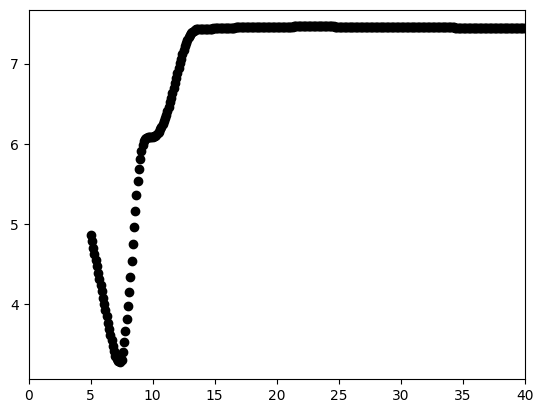

In [302]:
plt.plot(dfs[0]["Myr"], dfs[0]["Dnu"], 'o', color='black')
plt.xlim(0, 40)

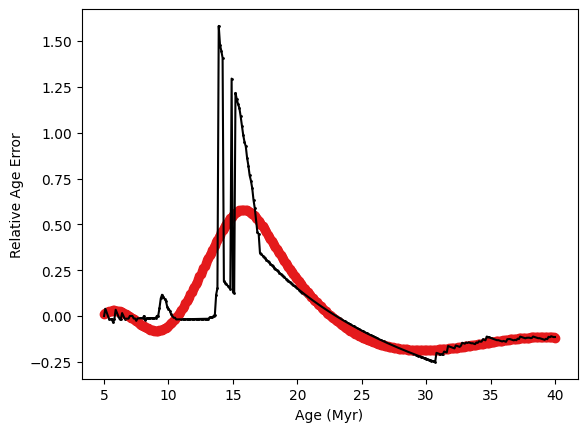

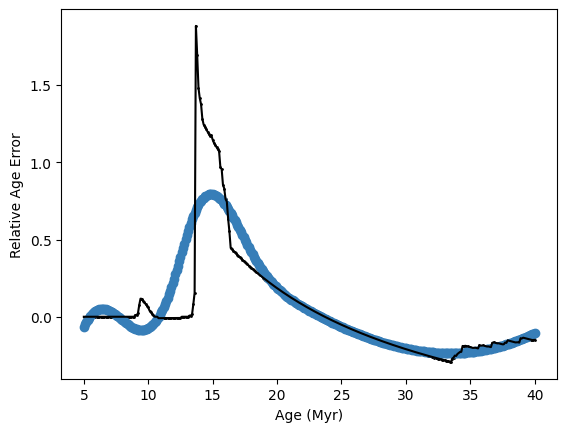

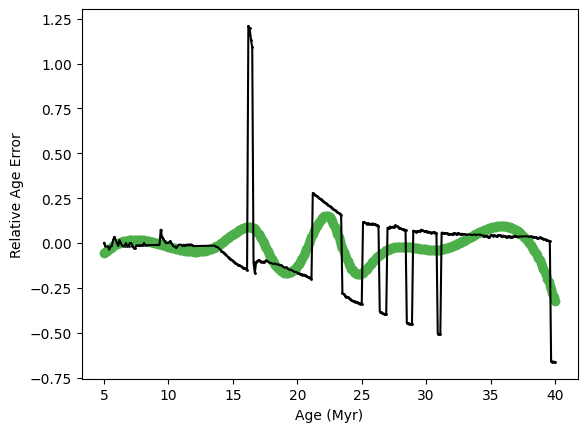

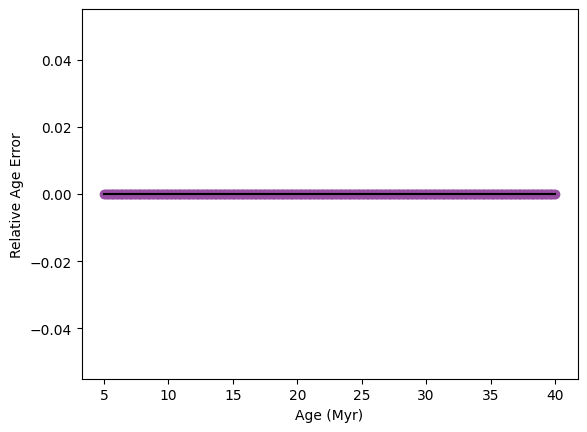

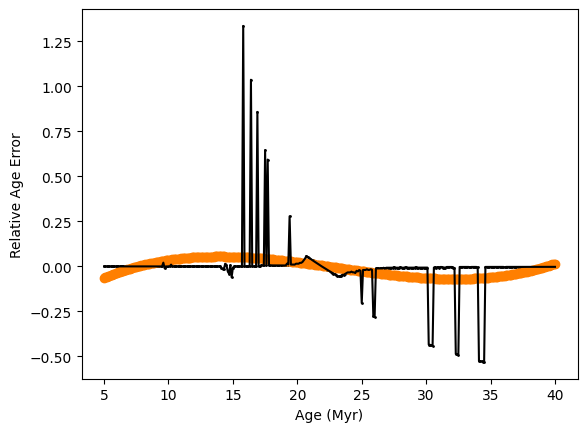

In [299]:
palette = plt.get_cmap('Set1')
age_rel_errs = []
for i, df in enumerate(dfs):
    age_rel_err, age_rel_err_dirty, age, age_dirty = age_uncertainty(df, dfs[3], cols0, cols1)
    age_rel_errs.append(age_rel_err)
    plt.plot(age, age_rel_err, '-o', color=palette(i))
    plt.scatter(age_dirty, age_rel_err_dirty, color='k', s=1)
    plt.plot(age_dirty, age_rel_err_dirty, color='k')
    plt.xlabel("Age (Myr)")
    plt.ylabel("Relative Age Error")
    plt.show()

/var/folders/sb/dk38f76562ng2fhw85ll93vc0000gp/T/ipykernel_3171/1361153454.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(age, 100*np.array(age_rel_err), '-', color=palette[i], label=params[i], linestyle=linestyle_tuple[i])


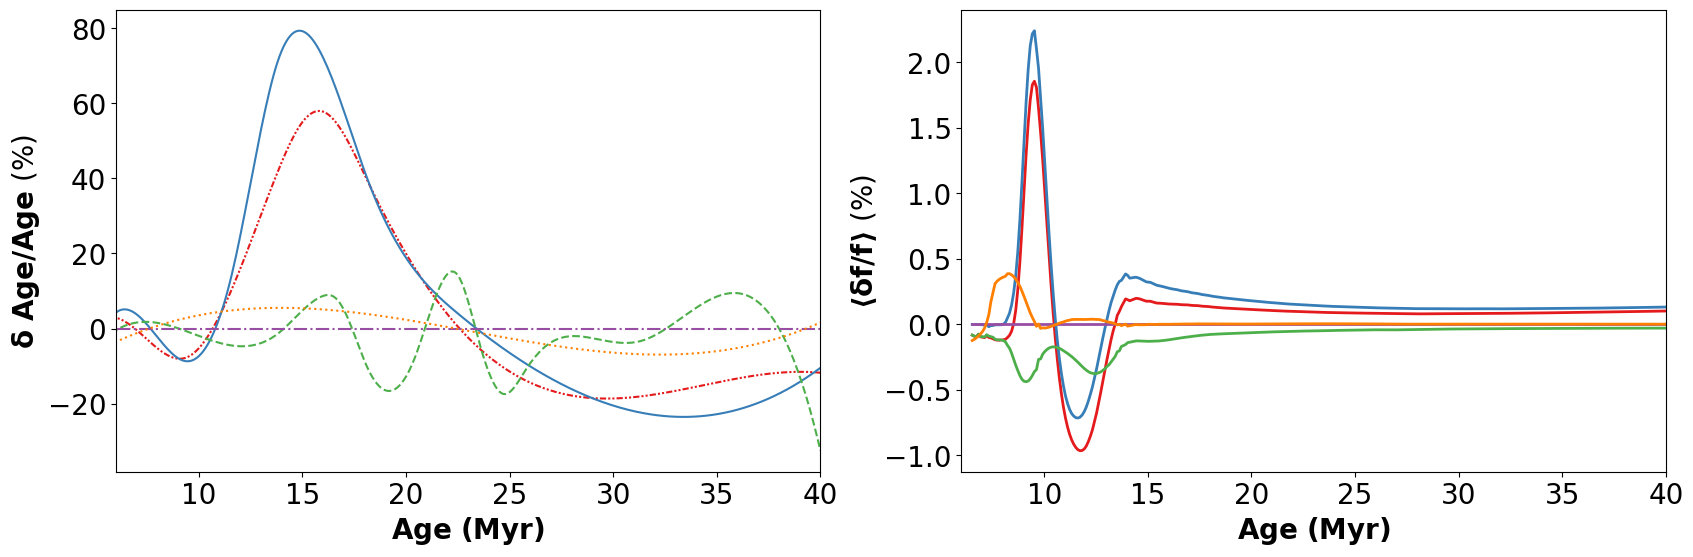

In [300]:
params = ["basic", "pp_extras", "hot_cno", "pp_and_cno_extras", "pp_and_hot_cno"]
linestyle_tuple = [(0, (3, 1, 1, 1, 1, 1)), 'solid', '--', '-.', ':']
palette = sns.color_palette("Set1", 5)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
for i, age_rel_err in enumerate(age_rel_errs):
    plt.plot(age, 100*np.array(age_rel_err), '-', color=palette[i], label=params[i], linestyle=linestyle_tuple[i])
plt.xlabel("Age (Myr)")
plt.ylabel("Relative Age Error")
plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\delta\ Age/Age}\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)
plt.xlim(6, 40)


plt.subplot(1, 2, 2)
for ind, df in enumerate(dfs):
    plt.plot(ages[ind], 100*np.array(mean_diffs[ind]), color=palette[ind], lw=2)
title_font = mpl.font_manager.FontProperties(weight='black',
                                   style='normal', size=20)
font = mpl.font_manager.FontProperties(weight='bold',
                                   style='normal', size=18)
plt.xlim([6, 40])

plt.xlabel(r'$\bf{Age\ (Myr)}$', size=20)
plt.ylabel(r'$\bf{\langle{\delta f/f}} \rangle\ \rm{(\%)}$', size=20)
plt.gca().xaxis.set_tick_params(labelsize=20)
plt.gca().yaxis.set_tick_params(labelsize=20)


plt.savefig("age_uncertainty.png", dpi=300)
plt.show()